In [5]:
#20 min interval, video playback of max/medium/min brightness, then standby mode

In [3]:
import sys
import logging
from uuid import UUID

import arrow
import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import public_data


logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)


android_id = "248d8da2-9288-41b2-a0fe-29c1f2f01932"

In [4]:
# pull data from the server 
# for the videoplay of different brightness done on 10/12/16
server_url = 'https://e-mission.eecs.berkeley.edu'

#overall
start_ts = arrow.get('2016-10-12 21:04:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts = arrow.get('2016-10-12 22:22:00', 'YYYY-MM-DD HH:mm:ss').timestamp

phone_ids = [android_id]

public_data.request_batched_data(server_url, start_ts, end_ts, phone_ids)

Data loaded to local server!


In [5]:
#type: list of emission.storage.timeseries.builtin_timeseries.BuiltinTimeSeries
android_ts = esta.TimeSeries.get_time_series(UUID(android_id))

#time query specification
#overall
start_ts = arrow.get('2016-10-12 21:04:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts = arrow.get('2016-10-12 22:22:00', 'YYYY-MM-DD HH:mm:ss').timestamp

#max brightness
start_ts0 = arrow.get('2016-10-12 21:04:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts0 = arrow.get('2016-10-12 21:25:00', 'YYYY-MM-DD HH:mm:ss').timestamp

#medium brightness
start_ts1 = arrow.get('2016-10-12 21:25:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts1 = arrow.get('2016-10-12 21:45:00', 'YYYY-MM-DD HH:mm:ss').timestamp

#min brightness
start_ts2 = arrow.get('2016-10-12 21:45:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts2 = arrow.get('2016-10-12 22:05:00', 'YYYY-MM-DD HH:mm:ss').timestamp

#standby mode
start_ts3 = arrow.get('2016-10-12 22:05:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts3 = arrow.get('2016-10-12 22:22:00', 'YYYY-MM-DD HH:mm:ss').timestamp

start_ts_list = [start_ts0, start_ts1, start_ts2, start_ts3]
end_ts_list = [end_ts0, end_ts1, end_ts2, end_ts3]

time_range = estt.TimeQuery("metadata.write_ts", start_ts, end_ts)
time_range0 = estt.TimeQuery("metadata.write_ts", start_ts0, end_ts0)
time_range1 = estt.TimeQuery("metadata.write_ts", start_ts1, end_ts1)
time_range2 = estt.TimeQuery("metadata.write_ts", start_ts2, end_ts2)
time_range3 = estt.TimeQuery("metadata.write_ts", start_ts3, end_ts3)

android_battery_df = android_ts.get_data_df("background/battery", time_range)
android_battery_df0 = android_ts.get_data_df("background/battery", time_range0)
android_battery_df1 = android_ts.get_data_df("background/battery", time_range1)
android_battery_df2 = android_ts.get_data_df("background/battery", time_range2)
android_battery_df3 = android_ts.get_data_df("background/battery", time_range3)
android_battery_df_list = [android_battery_df0, android_battery_df1, android_battery_df2, android_battery_df3]

In [6]:
import numpy as np

android_xnew = np.arange(start_ts, end_ts, 30) # 30 seconds
android_xnew0 = np.arange(start_ts0, end_ts0, 30) # 30 seconds
android_xnew1 = np.arange(start_ts1, end_ts1, 30) # 30 seconds
android_xnew2 = np.arange(start_ts2, end_ts2, 30) # 30 seconds
android_xnew3 = np.arange(start_ts3, end_ts3, 30) # 30 seconds

In [7]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    #This class returns a function whose call method uses interpolation to find the value of new points.
    return fn(xnew)

In [8]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    #date.isoformat() Return a string representing the date in ISO 8601 format, ‘YYYY-MM-DD’. 
    # -For example, date(2002, 12, 4).isoformat() == '2002-12-04'.
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [9]:
android_battery_interp_df = get_interpolated_df(android_battery_df, android_xnew)
android_battery_interp_df0 = get_interpolated_df(android_battery_df0, android_xnew0)
android_battery_interp_df1 = get_interpolated_df(android_battery_df1, android_xnew1)
android_battery_interp_df2 = get_interpolated_df(android_battery_df2, android_xnew2)
android_battery_interp_df3 = get_interpolated_df(android_battery_df3, android_xnew3)
android_battery_interp_df_list = [android_battery_interp_df0, android_battery_interp_df1, android_battery_interp_df2, android_battery_interp_df3]

In [11]:
from scipy import stats


slope_list=[]
print "From linear model fitting ..." 
for i, df in enumerate(android_battery_interp_df_list):
    df['hr'] = (df.ts-start_ts)/3600.0
    df['m'] = df.hr*60.0
    notnull = df.battery_level_pct.notnull()
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.m[notnull], df.battery_level_pct[notnull])
    print "android %d: " % (i+1)  + "slope="+str(slope) + " %/min  std_err="+str(std_err)
    slope_list.append(slope)

print "average slope=" + str(sum(slope_list)/len(slope_list)) + " %/min  std dev=" + str(np.std(slope_list))

From linear model fitting ...
android 1: slope=-0.700360261691 %/min  std_err=0.00662549249177
android 2: slope=-0.481581264589 %/min  std_err=0.00751926655363
android 3: slope=-0.402416297989 %/min  std_err=0.00569830859284
android 4: slope=0.0 %/min  std_err=0.0
average slope=-0.396089456067 %/min  std dev=0.253385308678


In [12]:
label = ['max brightness ', 'medium brightness ', 'min brightness', 'stanby']
style = ['ob', 'og', 'or', 'oc']
style_interp = ['b', 'g', 'r', 'c']

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

In [ ]:
#Android: With interplation on battery data 

(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d

ifig.suptitle('Video Playing of Different Screen Brightness', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    df['hr'] = (df.ts-start_ts)/3600.0
    df['m'] = df.hr*60.0
    df.plot(x='m', y='battery_level_pct', style=style_interp[i], label=label[i]+"(avg slope=%s)" % round(slope_list[i], 3), ax=iaxes, legend=True)


for i, df in enumerate(android_battery_df_list):
    df['hr'] = (df.ts-start_ts)/3600.0
    df['m'] = df.hr*60.0
    df.plot(x='m', y='battery_level_pct', style=style[i], ax=iaxes, legend=False)
    iaxes.set_xlabel('Minutes')
    iaxes.set_ylabel('Batery Level')
    #plt.xticks(np.arange(min(df.dt), max(df.dt), 1))


156


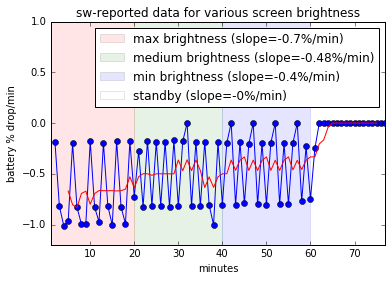

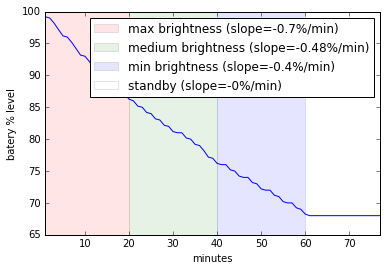

In [269]:
# Rolling Average

import numpy as np
itest_old = android_battery_interp_df
print len(itest_old)
itest = itest_old
itest = itest_old.iloc[::2, :] 

b = itest.battery_level_pct
delta_b = np.diff(itest.battery_level_pct)
#print delta_b
delta_b = np.insert(delta_b, 0, 1)
#print delta_b
ts = itest.metadata_write_ts

rate_df = pd.DataFrame({'delta_b':delta_b, 'ts':ts, 'b':b})
#rate_df = rate_df[rate_df.delta_b!=0]
#print delta_b
delta_b = rate_df.delta_b[1:]
delta_t = np.diff(rate_df.ts)/60.0 #convert from seconds to min 
#print len(delta_b)
#print len(delta_t)

slope_df = pd.DataFrame({'delta_b':delta_b, 'delta_t':delta_t})
slope_df['slope'] = (delta_b/delta_t)[1:]
slope_df['ts'] = rate_df.ts[1:]
slope_df['minutes'] = ((slope_df.ts-start_ts)/60.0)
slope_df['fmt_time'] = slope_df.ts.apply(ts_to_dt)
slope_df['b'] = rate_df.b[1:]

#remove outliners 
#slope_df = slope_df[slope_df.slope>-10 ]
#slope_df = slope_df[slope_df.slope<-2 ]

#_, breaks=np.histogram(df.MAT,bins=1)
#(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
#iaxes = iaxes2d

#ax = slope_df.boxplot(column='slope')
#slope_df.slope.describe()

ax = slope_df.plot(x='minutes', y='slope', style='-o')
ax.set_ylabel('battery % drop/min')

from matplotlib.patches import Rectangle
import numpy as np
import pylab as P

ax.axvspan(0, 20, alpha=0.1, color='red') 
ax.axvspan(20, 40, alpha=0.1, color='green')
ax.axvspan(40, 60, alpha=0.1, color='blue')


new_df = pd.DataFrame(data={'minutes': slope_df.minutes, 'slope': slope_df.slope})
new_df = new_df.reset_index(drop=True)
new_df = new_df.set_index([list(slope_df.minutes)])
new_df.slope.rolling(window=6, center=True).mean().plot(style='r')

rect0 = Rectangle((0, 0), 1, 1, fc="r", alpha=0.1)
rect1 = Rectangle((0, 0), 1, 1, fc="g", alpha=0.1)
rect2 = Rectangle((0, 0), 1, 1, fc="b", alpha=0.1)
rect3 = Rectangle((0, 0), 1, 1, fc="w", alpha=0.1)

P.legend([rect0, rect1, rect2, rect3], ["max brightness (slope=-0.7%/min)", "medium brightness (slope=-0.48%/min)", "min brightness (slope=-0.4%/min)", "standby (slope=-0%/min)"])
ax.set_title("sw-reported data for various screen brightness")
ax.set_ylim([-1.2,1])

ax1 = slope_df.plot(x='minutes', y='b', style='-')
ax1.set_ylabel('batery % level')

ax1.axvspan(0, 20, alpha=0.1, color='red') 
ax1.axvspan(20, 40, alpha=0.1, color='green')
ax1.axvspan(40, 60, alpha=0.1, color='blue')

P.legend([rect0, rect1, rect2, rect3], ["max brightness (slope=-0.7%/min)", "medium brightness (slope=-0.48%/min)", "min brightness (slope=-0.4%/min)", "standby (slope=-0%/min)"])


(-1, 0.5)

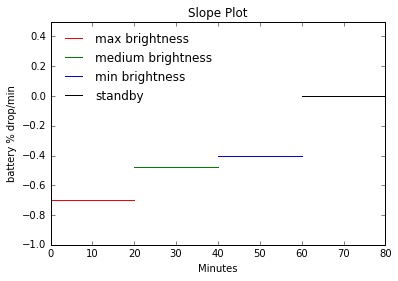

In [175]:
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)


#line, = ax.plot((0, 20), (-0.7, -0.7), 'r-', label='max brightness')

ax.set_title("Slope Plot")
ax.set_xlabel("Minutes")
ax.set_ylabel("battery % drop/min")

plt.plot((0, 20), (-0.7, -0.7), 'r-', label='max brightness')
plt.plot((20, 40), (-0.48, -0.48), 'g-', label='medium brightness')
plt.plot((40, 60), (-0.4, -0.4), 'b-', label='min brightness')
ax = plt.plot((60, 80), (0, 0), 'k-', label='standby')
plt.legend(loc='upper left', frameon=False)
plt.xlim(0,80)
plt.ylim(-1, 0.5)
